In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.99it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 144.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.53it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.35it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 3
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### Exact Method with Clarabel

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=1)

(CVXPY) Nov 29 04:05:22 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 1


In [14]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                            | 0/3 [00:09<?, ?it/s]

Epoch   0, Train Regret: 216.6579%, Val Regret: 224.0108%


Epoch    0, Loss:  -0.9971:  33%|██████████████████▋                                     | 1/3 [00:27<00:36, 18.44s/it]

Epoch   1, Train Regret:  12.3158%, Val Regret:  14.5874%


Epoch    1, Loss:  -0.9987:  67%|█████████████████████████████████████▎                  | 2/3 [00:48<00:18, 18.60s/it]

Epoch   2, Train Regret:   8.0763%, Val Regret:   9.0965%


Epoch    2, Loss:  -0.9987: 100%|████████████████████████████████████████████████████████| 3/3 [00:58<00:00, 19.65s/it]


Epoch   2, Train Regret:   7.3354%, Val Regret:   8.1598%

Evaluation:
Test Regret: 8.0063%
Training Elapsed Time: 26.54 Sec


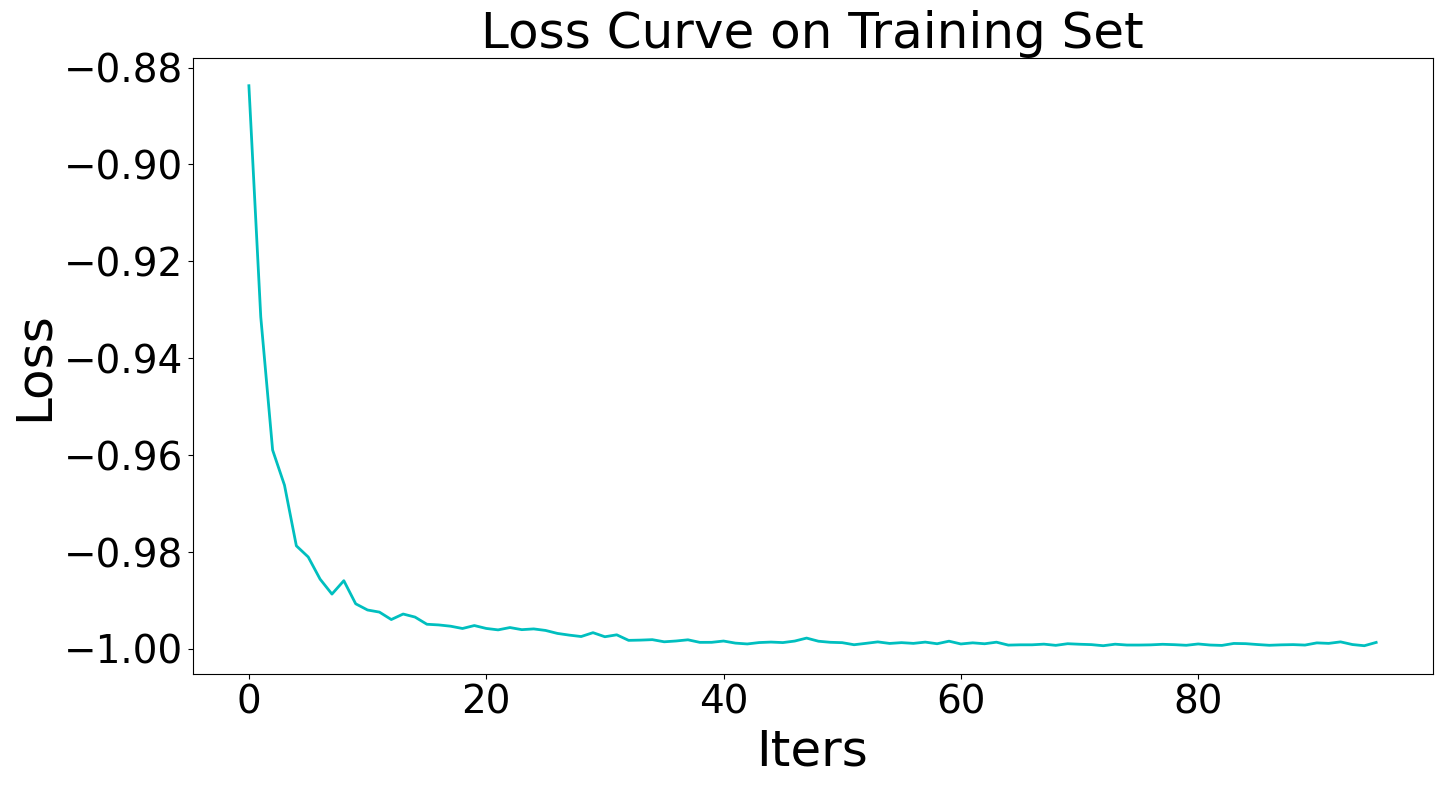

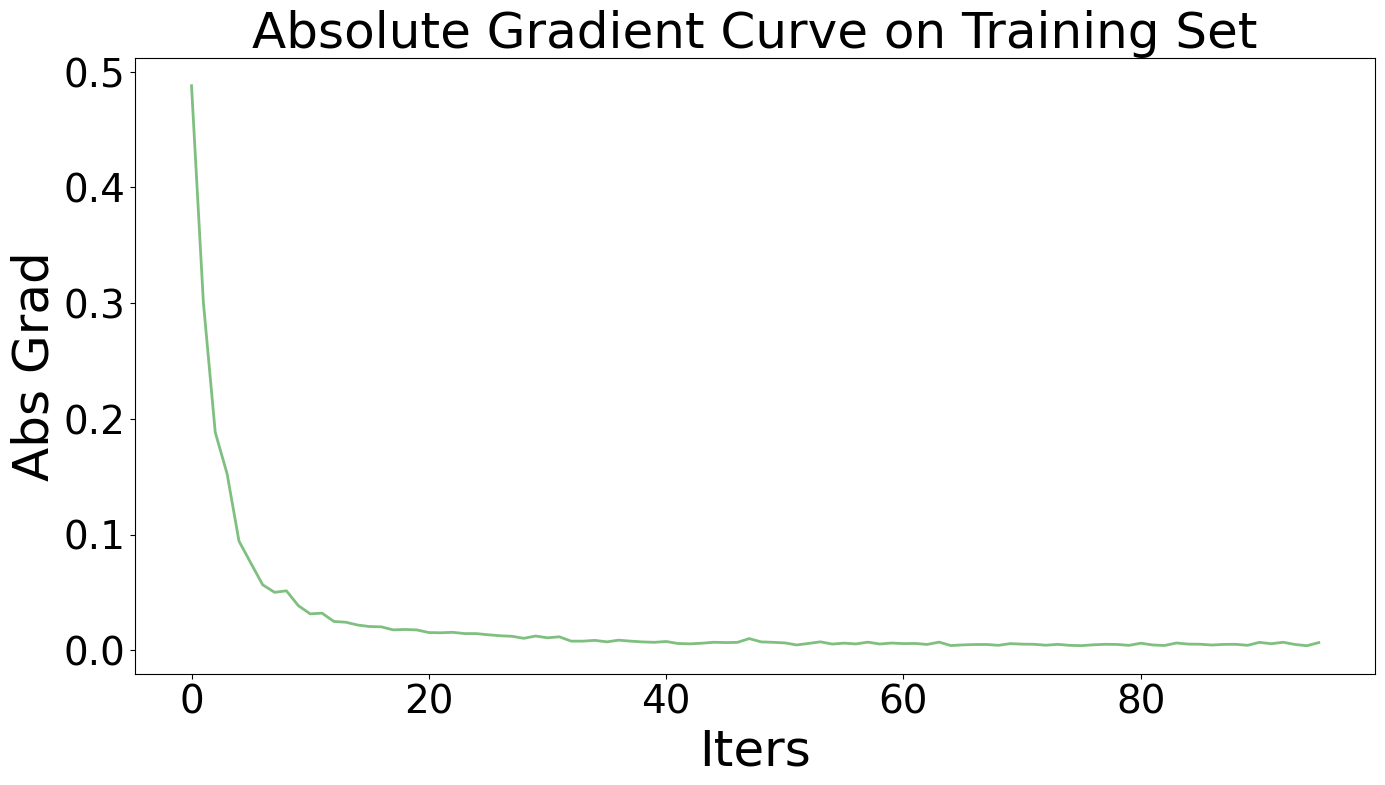

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Check Gradient 

In [16]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-1)
# init log
grad_log = []
# train
for data in loader_train:
    # unzip data
    x, c, w, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(grad.detach()))
    # loss
    loss = ca_cos(cp, t_ctr, reduction="none")
    # backward pass
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()
    for i in range(batch_size):
        print("True Obj:", (c[i]@w[i]).item())
        optmodel.setObj(cp[i].cpu().detach().numpy())
        sol, obj = optmodel.solve()
        print("Pred Obj:", (c[i]@sol).item())
        print("Loss:", loss[i].item())
        print("Grad:", grad_log[-1][i])
        print()
    break

True Obj: 37.909698486328125
Pred Obj: 38.65810012817383
Loss: -0.998901903629303
Grad: tensor([-9.9633e-08, -3.1853e-07,  4.1940e-08, -8.7250e-08, -2.2902e-07,
        -2.4952e-07, -1.8306e-07, -1.2900e-07, -2.8634e-07, -1.1022e-07,
        -9.7360e-08, -1.3069e-07, -3.0085e-07, -1.4471e-07, -4.1950e-09,
        -2.6517e-07, -5.4099e-08, -3.0850e-07, -2.8986e-07, -1.3754e-07,
        -2.3000e-07,  2.8437e-07,  9.9863e-08,  4.0898e-08, -1.1795e-07,
         1.9513e-08, -6.1535e-08,  2.9863e-08,  1.9457e-08,  5.7832e-09,
         1.0501e-07, -1.3674e-08, -1.5525e-08, -9.6297e-08, -3.5512e-08,
         3.5867e-08,  1.8755e-08, -5.6951e-08, -2.6148e-07, -7.1486e-08,
        -1.1231e-07,  6.1602e-08, -2.3501e-07, -1.4281e-08, -2.1670e-07,
         8.2029e-08, -6.4629e-08, -1.9917e-08, -2.2431e-07, -3.7999e-09,
         4.2728e-08, -1.4013e-07,  4.3960e-08, -9.4136e-08, -5.7747e-08,
         5.4202e-08, -5.2663e-08, -1.5734e-07, -1.3595e-09, -1.6027e-07,
        -6.0636e-08,  6.4272e-08, -5

Pred Obj: 35.72249984741211
Loss: -0.9990325570106506
Grad: tensor([ 2.9950e-09, -1.0599e-07,  2.0326e-06,  1.0005e-06, -1.2853e-07,
        -4.0756e-08, -2.0959e-09,  2.1389e-08,  1.5862e-09, -6.6466e-08,
        -7.3210e-09, -2.6808e-08,  8.5752e-09,  8.6475e-09,  3.6880e-08,
        -3.3922e-08, -2.7432e-06,  1.4286e-08,  1.6384e-08, -2.1690e-07,
        -6.7837e-08,  3.4051e-08, -2.1907e-10,  2.2056e-08, -1.1121e-07,
        -2.2243e-07,  9.4995e-08, -4.8407e-08, -6.2635e-08,  9.5209e-06,
        -5.2430e-06, -1.7107e-07,  3.2751e-08, -1.4458e-07, -3.0263e-06,
        -1.2651e-08, -9.4073e-07, -1.4189e-07, -1.3418e-07, -1.6457e-07,
        -4.5328e-06, -5.9720e-09,  2.0598e-08, -2.4826e-09, -1.7095e-07,
        -1.9136e-07, -9.1695e-08, -2.7982e-08, -1.9400e-07,  2.0127e-08,
         7.9042e-06,  1.8526e-08,  1.8686e-06, -4.9833e-06, -7.8220e-08,
        -2.8680e-06,  1.4955e-08, -5.2538e-08, -5.1266e-09, -7.4091e-08,
        -6.1504e-08, -2.9790e-08, -5.7147e-08, -1.5125e-07, -1.6